In [373]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dimc import dimc, DimTrack

dimtrack = DimTrack(2)
x = torch.randn(1,3,224,224) # b c h w

In [374]:
PATCH_SIZE = 4
WINDOW_SIZE = 7

@dimtrack
def patch_embedding(x):
    b, c, h, w = x.shape
    assert h % PATCH_SIZE == 0
    assert w % PATCH_SIZE == 0

    n_h = h // PATCH_SIZE
    n_w = w // PATCH_SIZE

    embed_dim = 96 # 2*(c*PATCH_SIZE**2)

    conv_proj = nn.Conv2d(
        in_channels=c,
        out_channels=embed_dim,
        kernel_size=PATCH_SIZE,
        stride=PATCH_SIZE,
    )

    norm = nn.LayerNorm(embed_dim)

    x = conv_proj(x)       # b n_x n_h n_w
    x = x.permute(0,2,3,1) # b n_h n_w n_x 
    x = norm(x)
    return x

In [375]:
@dimtrack
def shifted_window_attention(x, shift_size=0):
    b, n_h, n_w, n_x = x.shape

    @dimtrack
    def pad_patches(x):
        b, n_h, n_w, n_x = x.shape
        pad_r = (WINDOW_SIZE - n_w % WINDOW_SIZE) % WINDOW_SIZE # 0 <= pad < WINDOW_SIZE
        pad_b = (WINDOW_SIZE - n_h % WINDOW_SIZE) % WINDOW_SIZE # 0 <= pad < WINDOW_SIZE
        x = F.pad(x, (
            0,     0, # x_start, x_end
            0, pad_r, # w_start, w_end
            0, pad_b, # h_start, h_end
        ))
        return x
    
    @dimtrack
    def cyclic_shift(x):
        b, n_h, n_w, n_x = x.shape
        x = torch.roll(x, shifts=(-shift_size, -shift_size), dims=(1,2)) # upper left becomes lower right
        return x
    
    @dimtrack
    def reshape_by_windowsize(x):
        b, n_h, n_w, n_x = x.shape
        x = x.view(
            b,
            n_h//WINDOW_SIZE, WINDOW_SIZE, # n-times, self-attention
            n_w//WINDOW_SIZE, WINDOW_SIZE, # n-times, self-attention
            n_x
        )
        return x
    
    @dimtrack
    def batchify_windows(x):
        x = x.permute(0,1,3, 2,4, 5)
        x = x.reshape(
            b*(n_h//WINDOW_SIZE)*(n_w//WINDOW_SIZE),
            WINDOW_SIZE*WINDOW_SIZE,
            n_x
        )
        return x
    
    @dimtrack
    def mha(x, num_heads=8, cosine_attn=True):

        @dimtrack
        def attention_value(x):
            b, n_t, n_x = x.shape

            qkv_proj = nn.Linear(n_x, 3*n_x, bias=True)
            qkv = qkv_proj(x)
            qkv = qkv.reshape(b, n_t, 3, num_heads, n_x//num_heads)
            qkv = qkv.permute(2,0,3,1,4) # 3 b h n_t n_x' # always put ~ n_t n_x' at the end.
            q, k, v = qkv

            if cosine_attn:
                attn = F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2,-1)
            else:
                q = q * (n_x//num_heads) ** -0.5
                attn = q @ k.transpose(-2,-1)
            return attn

        @dimtrack
        def attn_add_relative_position_bias(attn):
            return attn
        
        x = attention_value(x)
        x = attn_add_relative_position_bias(x)
        return x

    
    @dimtrack
    def unpad_patches(x):
        x = x[:,:n_h,:n_w,:]
        return x
    
    x = pad_patches(x)
    x = cyclic_shift(x)
    x = reshape_by_windowsize(x)
    x = batchify_windows(x)
    x = mha(x)

    x = torch.randn(b, n_h, n_w, n_x)

    return x

In [376]:
@dimtrack
def mlp(x, ratio=4):
    b, n_h, n_w, n_x = x.shape
    fc1 = nn.Linear(n_x, ratio*n_x)
    fc2 = nn.Linear(4*n_x, n_x)
    nl = nn.GELU()

    x = fc1(x)
    x = nl(x)
    x = fc2(x)
    return x

In [377]:
def stochastic_depth(x, p=0):
    return x

In [378]:
@dimtrack
def swin_transformer_block(x, shift_size=0):
    b, n_h, n_w, n_x = x.shape
    norm1 = nn.LayerNorm(n_x)
    norm2 = nn.LayerNorm(n_x)

    x = norm1(x)
    x = x + stochastic_depth(shifted_window_attention(x, shift_size=shift_size))
    x = norm2(x)
    x = x = stochastic_depth(mlp(x))
    return x

In [379]:
@dimtrack
def swin_t(x):
    x = patch_embedding(x)
    x = swin_transformer_block(x, shift_size=0)
    x = swin_transformer_block(x, shift_size=WINDOW_SIZE//2)
    return x

swin_t(x)
dimtrack.show()

╭───── (1, 3, 224, 224) :: swin_t
│  ╭──── (1, 3, 224, 224) :: patch_embedding
│  ╰───→ (1, 56, 56, 96)
│  ╭──── (1, 56, 56, 96) :: swin_transformer_block
│  │  ╭─── (1, 56, 56, 96) :: shifted_window_attention
│  │  │  ╭── (1, 56, 56, 96) :: pad_patches
│  │  │  ╰─→ (1, 56, 56, 96)
│  │  │  ╭── (1, 56, 56, 96) :: cyclic_shift
│  │  │  ╰─→ (1, 56, 56, 96)
│  │  │  ╭── (1, 56, 56, 96) :: reshape_by_windowsize
│  │  │  ╰─→ (1, 8, 7, 8, 7, 96)
│  │  │  ╭── (1, 8, 7, 8, 7, 96) :: batchify_windows
│  │  │  ╰─→ (64, 49, 96)
│  │  │  ╭── (64, 49, 96) :: mha
│  │  │  │  ╭─ (64, 49, 96) :: attention_value
│  │  │  │  ╰→ (64, 8, 49, 49)
│  │  │  │  ╭─ (64, 8, 49, 49) :: attn_add_relative_position_bias
│  │  │  │  ╰→ (64, 8, 49, 49)
│  │  │  ╰─→ (64, 8, 49, 49)
│  │  ╰──→ (1, 56, 56, 96)
│  │  ╭─── (1, 56, 56, 96) :: mlp
│  │  ╰──→ (1, 56, 56, 96)
│  ╰───→ (1, 56, 56, 96)
│  ╭──── (1, 56, 56, 96) :: swin_transformer_block
│  │  ╭─── (1, 56, 56, 96) :: shifted_window_attention
│  │  │  ╭── (1, 56, 

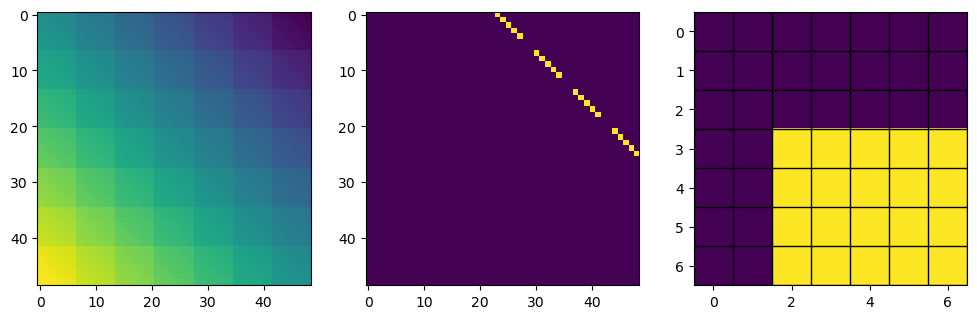

In [526]:
import matplotlib.pyplot as plt

def define_relative_position_index():
    coords_h = torch.arange(7)
    coords_w = torch.arange(7)
    coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww

    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2

    relative_coords[:, :, 0] += 7 - 1  # shift to start from 0
    relative_coords[:, :, 1] += 7 - 1
    relative_coords[:, :, 0] *= 2 * 7 - 1

    relative_position_index = relative_coords.sum(-1).flatten()  # Wh*Ww*Wh*Ww
    return relative_position_index

relative_position_index = define_relative_position_index()

i = 43
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(relative_position_index.reshape(49,49))
plt.subplot(1,3,2)
ab = relative_position_index==i
plt.imshow(ab.reshape(49,49))
plt.subplot(1,3,3)
plt.imshow(ab.type(torch.float32).reshape(49,7,7).mean(0))
for i in torch.linspace(-0.5,6.5,8):
    plt.axvline(i,c='k',lw=1)
    plt.axhline(i,c='k',lw=1)
plt.show()

jot down

In [381]:
from torchvision.models import swin_t

model = swin_t()

In [382]:
dimtrack = DimTrack()
x = torch.randn(1,3,224,224)
for module in model.features.children():
    x = dimtrack(module)(x)
dimtrack.show()

╭─ (1, 3, 224, 224) :: <class 'torch.nn.modules.container.Sequential'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torch.nn.modules.container.Sequential'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torchvision.models.swin_transformer.PatchMerging'>
╰→ (1, 28, 28, 192)
╭─ (1, 28, 28, 192) :: <class 'torch.nn.modules.container.Sequential'>
╰→ (1, 28, 28, 192)
╭─ (1, 28, 28, 192) :: <class 'torchvision.models.swin_transformer.PatchMerging'>
╰→ (1, 14, 14, 384)
╭─ (1, 14, 14, 384) :: <class 'torch.nn.modules.container.Sequential'>
╰→ (1, 14, 14, 384)
╭─ (1, 14, 14, 384) :: <class 'torchvision.models.swin_transformer.PatchMerging'>
╰→ (1, 7, 7, 768)
╭─ (1, 7, 7, 768) :: <class 'torch.nn.modules.container.Sequential'>
╰→ (1, 7, 7, 768)


In [383]:
dimtrack = DimTrack()
x = torch.randn(1,3,224,224)
for module in model.features[0].children():
    x = dimtrack(module)(x)
dimtrack.show()

╭─ (1, 3, 224, 224) :: <class 'torch.nn.modules.conv.Conv2d'>
╰→ (1, 96, 56, 56)
╭─ (1, 96, 56, 56) :: <class 'torchvision.ops.misc.Permute'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torch.nn.modules.normalization.LayerNorm'>
╰→ (1, 56, 56, 96)


In [384]:
dimtrack = DimTrack()
x = torch.randn(1,56,56,96)
for module in model.features[1].children():
    x = dimtrack(module)(x)
dimtrack.show()

╭─ (1, 56, 56, 96) :: <class 'torchvision.models.swin_transformer.SwinTransformerBlock'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torchvision.models.swin_transformer.SwinTransformerBlock'>
╰→ (1, 56, 56, 96)


In [385]:
dimtrack = DimTrack()
x = torch.randn(1,56,56,96)
for module in model.features[1][0].children():
    x = dimtrack(module)(x)
dimtrack.show()

╭─ (1, 56, 56, 96) :: <class 'torch.nn.modules.normalization.LayerNorm'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torchvision.models.swin_transformer.ShiftedWindowAttention'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torchvision.ops.stochastic_depth.StochasticDepth'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torch.nn.modules.normalization.LayerNorm'>
╰→ (1, 56, 56, 96)
╭─ (1, 56, 56, 96) :: <class 'torchvision.ops.misc.MLP'>
╰→ (1, 56, 56, 96)
